#Libraries

In [1]:
# libraries
import numpy as np # used for handling numbers
import pandas as pd # used for handling the dataset
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


#Read input

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv('/content/drive/MyDrive/metaverse_transactions_dataset.csv')

#Display input

In [4]:
df.head()

,timestamp,hour_of_day,sending_address,receiving_address,amount,transaction_type,location_region,ip_prefix,login_frequency,session_duration,purchase_pattern,age_group,risk_score,anomaly
0,2022-04-11 12:47:27,12,0x9d32d0bf2c00f41ce7ca01b66e174cc4dcb0c1da,0x39f82e1c09bc6d7baccc1e79e5621ff812f50572,796.949206,transfer,Europe,192.000,3,48,focused,established,18.75,low_risk
1,2022-06-14 19:12:46,19,0xd6e251c23cbf52dbd472f079147873e655d8096f,0x51e8fbe24f124e0e30a614e14401b9bbfed5384c,0.010000,purchase,South America,172.000,5,61,focused,established,25.00,low_risk
2,2022-01-18 16:26:59,16,0x2e0925b922fed01f6a85d213ae2718f54b8ca305,0x52c7911879f783d590af45bda0c0ef2b8536706f,778.197390,purchase,Asia,192.168,3,74,focused,established,31.25,low_risk
3,2022-06-15 09:20:04,9,0x93efefc25fcaf31d7695f28018d7a11ece55457f,0x8ac3b7bd531b3a833032f07d4e47c7af6ea7bace,300.838358,transfer,South America,172.000,8,111,high_value,veteran,36.75,low_risk
4,2022-02-18 14:35:30,14,0xad3b8de45d63f5cce28aef9a82cf30c397c6ceb9,0x6fdc047c2391615b3facd79b4588c7e9106e49f2,775.569344,sale,Africa,172.160,6,100,high_value,veteran,62.50,moderate_risk


In [5]:
df.columns

Index(['timestamp', 'hour_of_day', 'sending_address', 'receiving_address',
       'amount', 'transaction_type', 'location_region', 'ip_prefix',
       'login_frequency', 'session_duration', 'purchase_pattern', 'age_group',
       'risk_score', 'anomaly'],
      dtype='object')

In [6]:
df.shape

(78600, 14)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78600 entries, 0 to 78599
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          78600 non-null  object 
 1   hour_of_day        78600 non-null  int64  
 2   sending_address    78600 non-null  object 
 3   receiving_address  78600 non-null  object 
 4   amount             78600 non-null  float64
 5   transaction_type   78600 non-null  object 
 6   location_region    78600 non-null  object 
 7   ip_prefix          78600 non-null  float64
 8   login_frequency    78600 non-null  int64  
 9   session_duration   78600 non-null  int64  
 10  purchase_pattern   78600 non-null  object 
 11  age_group          78600 non-null  object 
 12  risk_score         78600 non-null  float64
 13  anomaly            78600 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 8.4+ MB


# Pre-processing


## Features

*   remove unuseful features
*   create new features using 'timestamp'
*   convert datatype

In [8]:
# Split the timestamp column into date and time columns
df['time'] = df['timestamp'].apply(lambda x: x.split()[1])

In [9]:
# Remove ":" from the time column and convert to integer
df['time'] = df['time'].str.replace(':', '').astype(int)

In [10]:
# Define bins for time categories
bins = [0, 60000, 120000, 180000, 240000]  # e.g., bins for Morning, Noon, Afternoon, Evening

# Define labels for the bins
labels = ['before 6am', '6am to 11.59pm', '12pm to 6pm','after 6pm']

# Bin the timestamp column into time categories
df['time_category'] = pd.cut(df['time'], bins=bins, labels=labels, right=False).astype(str)

In [11]:
df['time_category'].unique()

array(['12pm to 6pm', 'after 6pm', '6am to 11.59pm', 'before 6am'],
      dtype=object)

In [12]:
df.drop(columns=['timestamp','hour_of_day','sending_address', 'receiving_address','time'],inplace = True, axis=1)

In [13]:
df['ip_prefix'] = df['ip_prefix'].astype(str)

In [14]:
df.head()

,amount,transaction_type,location_region,ip_prefix,login_frequency,session_duration,purchase_pattern,age_group,risk_score,anomaly,time_category
0,796.949206,transfer,Europe,192.0,3,48,focused,established,18.75,low_risk,12pm to 6pm
1,0.010000,purchase,South America,172.0,5,61,focused,established,25.00,low_risk,after 6pm
2,778.197390,purchase,Asia,192.168,3,74,focused,established,31.25,low_risk,12pm to 6pm
3,300.838358,transfer,South America,172.0,8,111,high_value,veteran,36.75,low_risk,6am to 11.59pm
4,775.569344,sale,Africa,172.16,6,100,high_value,veteran,62.50,moderate_risk,12pm to 6pm


In [15]:
df.duplicated().sum()

21

In [16]:
df.isnull().sum()

amount              0
transaction_type    0
location_region     0
ip_prefix           0
login_frequency     0
session_duration    0
purchase_pattern    0
age_group           0
risk_score          0
anomaly             0
time_category       0
dtype: int64

In [17]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [18]:
#check
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78579 entries, 0 to 78599
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   amount            78579 non-null  float64
 1   transaction_type  78579 non-null  object 
 2   location_region   78579 non-null  object 
 3   ip_prefix         78579 non-null  object 
 4   login_frequency   78579 non-null  int64  
 5   session_duration  78579 non-null  int64  
 6   purchase_pattern  78579 non-null  object 
 7   age_group         78579 non-null  object 
 8   risk_score        78579 non-null  float64
 9   anomaly           78579 non-null  object 
 10  time_category     78579 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 7.2+ MB


## Outliers

In [19]:
df.describe()

,amount,login_frequency,session_duration,risk_score
count,78579.000000,78579.000000,78579.000000,78579.000000
mean,502.709212,4.178954,69.688403,44.958343
std,245.793694,2.366052,40.524867,21.775328
min,0.010000,1.000000,20.000000,15.000000
25%,331.503978,2.000000,35.000000,26.250000
50%,500.115208,4.000000,60.000000,40.000000
75%,669.568551,6.000000,100.000000,52.500000
max,1557.150905,8.000000,159.000000,100.000000


In [20]:
fig = px.box(df, y='amount')
fig.show()

## Data Exploratory Analysis

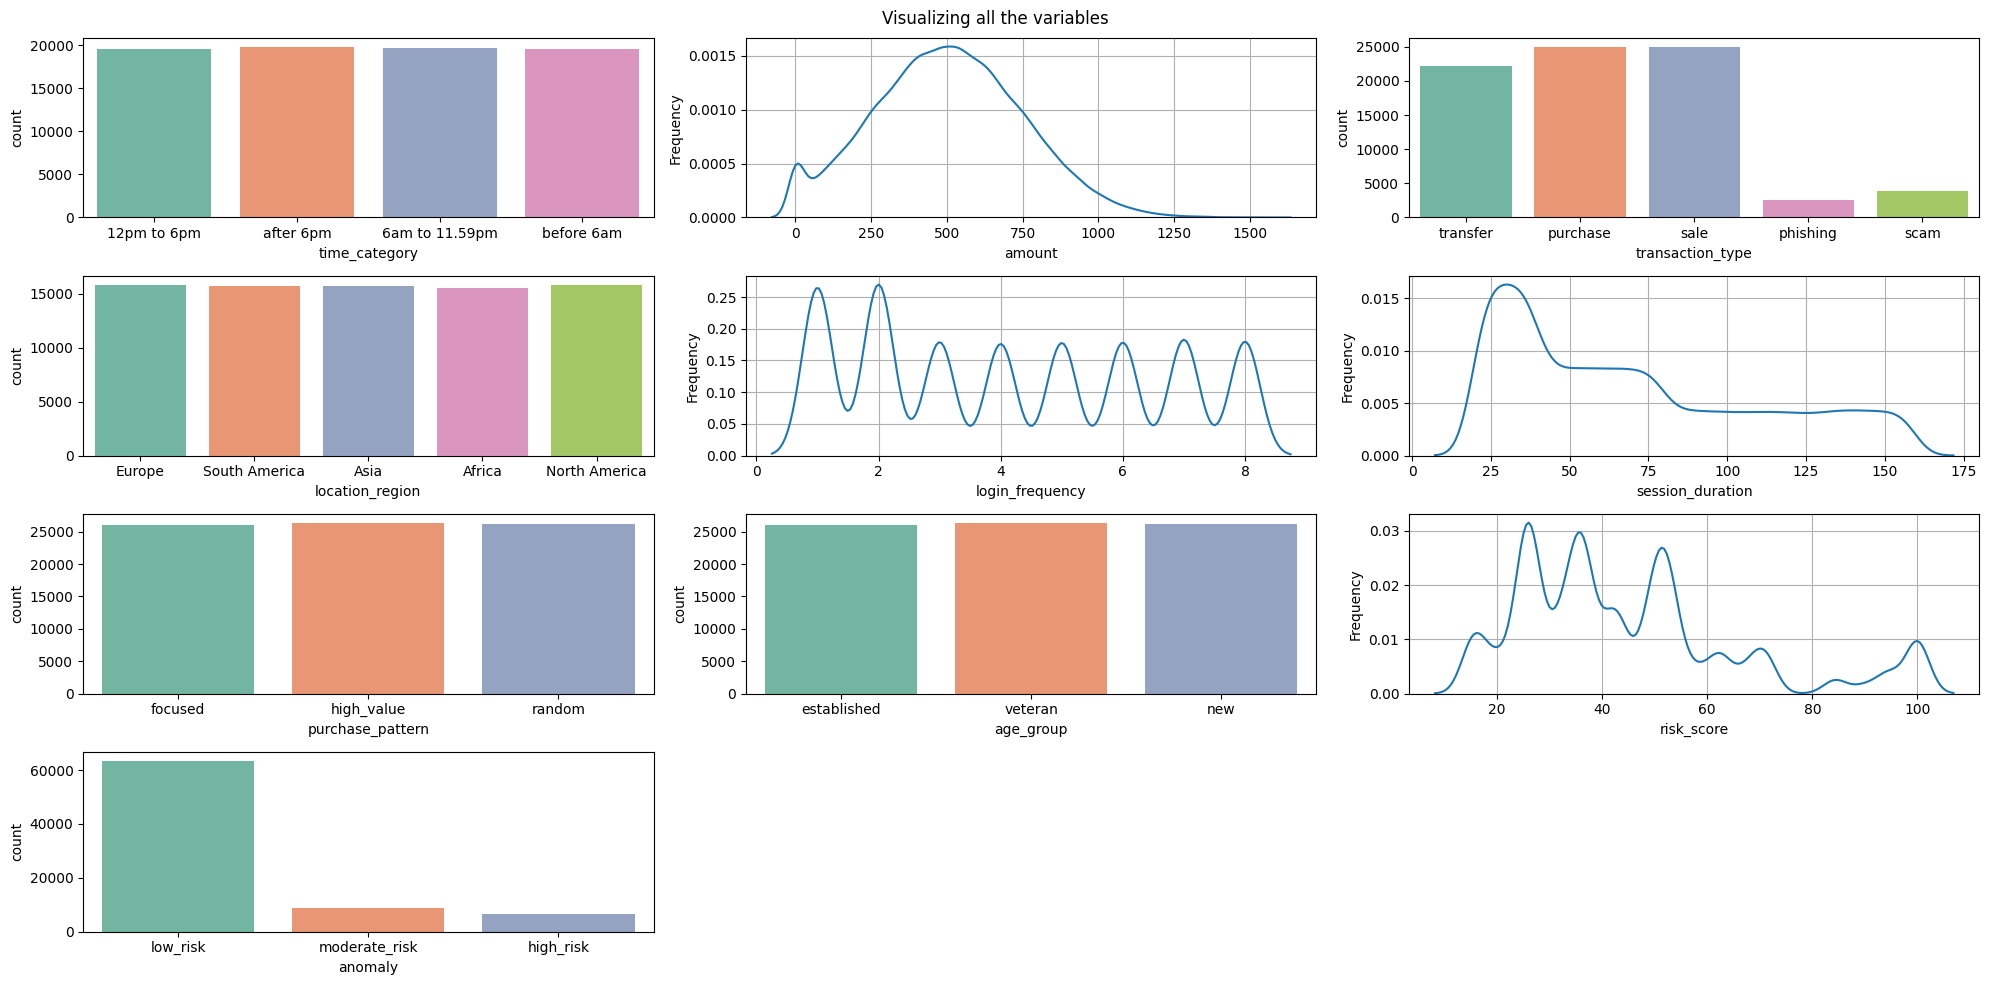

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

r=4
c=3
it=1
plt.figure(figsize=(20, 10))


cols = ['time_category','amount', 'transaction_type', 'location_region',
       'login_frequency', 'session_duration', 'purchase_pattern', 'age_group',
       'risk_score', 'anomaly']

set2 = sns.color_palette("Set2")


for i in cols:
    plt.suptitle("Visualizing all the variables")
    plt.subplot(r,c,it)
    if df[i].dtype=='object':
        unique_values = df[i].nunique()
        extended_palette = sns.color_palette("Set2", n_colors=unique_values)
        sns.countplot(x=df[i], hue=df[i], palette=extended_palette, legend=False)
        plt.xlabel(i)
    else:
        sns.kdeplot(df[i])
        plt.xlabel(i)
        plt.ylabel('Frequency')
        plt.grid()
    it+=1


plt.tight_layout()
plt.show()

## Extracting independent variable

In [22]:
X = df.drop(['anomaly'], axis=1)
X

,amount,transaction_type,location_region,ip_prefix,login_frequency,session_duration,purchase_pattern,age_group,risk_score,time_category
0,796.949206,transfer,Europe,192.0,3,48,focused,established,18.7500,12pm to 6pm
1,0.010000,purchase,South America,172.0,5,61,focused,established,25.0000,after 6pm
2,778.197390,purchase,Asia,192.168,3,74,focused,established,31.2500,12pm to 6pm
3,300.838358,transfer,South America,172.0,8,111,high_value,veteran,36.7500,6am to 11.59pm
4,775.569344,sale,Africa,172.16,6,100,high_value,veteran,62.5000,12pm to 6pm
...,...,...,...,...,...,...,...,...,...,...
78595,660.280373,transfer,Africa,172.0,1,27,random,new,26.2500,12pm to 6pm
78596,310.273397,purchase,Africa,172.0,5,60,focused,established,26.2500,12pm to 6pm
78597,624.674332,purchase,Africa,192.0,1,34,random,new,36.7500,12pm to 6pm
78598,401.391592,purchase,Asia,192.168,4,56,focused,established,35.4375,before 6am


##Extracting dependent variable

In [23]:
y = df['anomaly']
y

0             low_risk
1             low_risk
2             low_risk
3             low_risk
4        moderate_risk
             ...      
78595         low_risk
78596         low_risk
78597         low_risk
78598         low_risk
78599         low_risk
Name: anomaly, Length: 78579, dtype: object

<Axes: ylabel='count'>

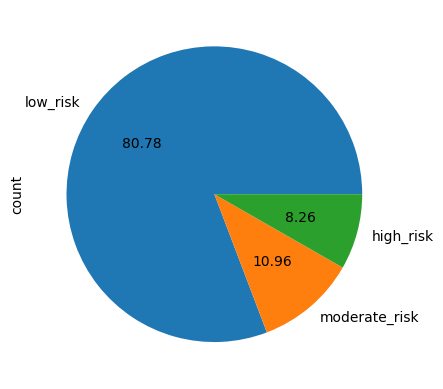

In [24]:
y.value_counts().plot.pie(autopct='%.2f')

## Label Encoder


In [25]:
X.nunique()

amount              76771
transaction_type        5
location_region         5
ip_prefix               5
login_frequency         8
session_duration      140
purchase_pattern        3
age_group               3
risk_score             31
time_category           4
dtype: int64

In [26]:
y.unique()

array(['low_risk', 'moderate_risk', 'high_risk'], dtype=object)

In [27]:
# Mapping the risk level
risk_mapping = {
    'low_risk': '0',
    'moderate_risk':'1',
    'high_risk': '2',
}

In [28]:
y = y.map(risk_mapping).fillna(df['anomaly'])
y.head()

0    0
1    0
2    0
3    0
4    1
Name: anomaly, dtype: object

## Normalisation

In [29]:
scaler = StandardScaler()

col_to_standardized=['amount', 'login_frequency','session_duration','risk_score']

X[col_to_standardized] = scaler.fit_transform(X[col_to_standardized])

## One Hot encoding

In [30]:
X = pd.get_dummies(X,columns = ['time_category','transaction_type','location_region','ip_prefix','purchase_pattern','age_group'],dtype = int)

X.head()

,amount,login_frequency,session_duration,risk_score,time_category_12pm to 6pm,time_category_6am to 11.59pm,time_category_after 6pm,time_category_before 6am,transaction_type_phishing,transaction_type_purchase,...,ip_prefix_172.0,ip_prefix_172.16,ip_prefix_192.0,ip_prefix_192.168,purchase_pattern_focused,purchase_pattern_high_value,purchase_pattern_random,age_group_established,age_group_new,age_group_veteran
0,1.197109,-0.498282,-0.535191,-1.203587,1,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
1,-2.045221,0.347013,-0.214398,-0.916563,0,0,1,0,0,1,...,1,0,0,0,1,0,0,1,0,0
2,1.120818,-0.498282,0.106395,-0.629540,1,0,0,0,0,1,...,0,0,0,1,1,0,0,1,0,0
3,-0.821307,1.614956,1.019420,-0.376959,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
4,1.110126,0.769661,0.747980,0.805580,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1


## Splitting data

In [31]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<Axes: ylabel='count'>

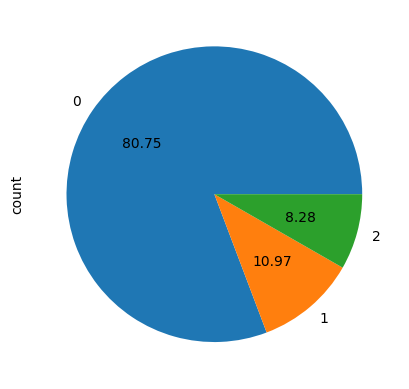

In [32]:
y_train.value_counts().plot.pie(autopct='%.2f')

# Model Development and Prediction

## Random Forest

In [33]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
rf_model = Pipeline([
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE to balance the classes
    ('clf', RandomForestClassifier(random_state=42))   # Random Forest classifier
])

In [34]:
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [35]:
print("rf_pred : ",rf_pred,"\n")

rf_pred :  ['0' '0' '0' ... '0' '0' '0'] 



In [36]:
rf_conf_matrix = confusion_matrix(y_test, rf_pred)
rf_conf_matrix

array([[12711,     0,     0],
       [    0,  1715,     0],
       [    0,     0,  1290]])

In [37]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, rf_pred)
precision = precision_score(y_test, rf_pred, average='weighted')
recall = recall_score(y_test, rf_pred, average='weighted')
f1 = f1_score(y_test, rf_pred, average='weighted')

# Print the evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Evaluation Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


## K-Nearest Neighbors (KNN)

In [38]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

In [39]:
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

In [40]:
print("knn_pred : ",knn_pred,"\n")

knn_pred :  ['0' '0' '0' ... '0' '0' '0'] 



In [41]:
knn_conf_matrix = confusion_matrix(y_test, knn_pred)
knn_conf_matrix

array([[12697,    14,     0],
       [   17,  1698,     0],
       [    0,     0,  1290]])

In [42]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, knn_pred)
precision = precision_score(y_test, knn_pred, average='weighted')
recall = recall_score(y_test, knn_pred, average='weighted')
f1 = f1_score(y_test, knn_pred, average='weighted')

# Print the evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Evaluation Metrics:
Accuracy: 0.9980274879104097
Precision: 0.9980261821465906
Recall: 0.9980274879104097
F1-score: 0.9980267409130542


## Naive Bayes

In [43]:
nb_model = Pipeline([
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE to balance the classes
    ('nb', GaussianNB())
])

In [44]:
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)

In [45]:
print("nb_pred : ",nb_pred,"\n")

nb_pred :  ['0' '0' '0' ... '0' '1' '0'] 



In [46]:
nb_conf_matrix = confusion_matrix(y_test, nb_pred)
nb_conf_matrix

array([[10131,  2580,     0],
       [    0,  1715,     0],
       [    0,     0,  1290]])

In [47]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, nb_pred)
precision = precision_score(y_test, nb_pred, average='weighted')
recall = recall_score(y_test, nb_pred, average='weighted')
f1 = f1_score(y_test, nb_pred, average='weighted')

# Print the evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Evaluation Metrics:
Accuracy: 0.8358360906082972
Precision: 0.9344491025362585
Recall: 0.8358360906082972
F1-score: 0.8618014608374724


# Model evaluation

In [48]:
from sklearn import metrics

def evaluate_model(model_name, y_test, y_pred):
    print(f"{model_name} Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"{model_name} Precision: {precision_score(y_test, y_pred, average='weighted')}")
    print(f"{model_name} Recall: {recall_score(y_test, y_pred, average='weighted')}")
    print(f"{model_name} F1 score: {f1_score(y_test, y_pred, average='weighted')}")
    print(f"Confusion Matrix for {model_name}:")
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


Random Forest Accuracy: 1.0
Random Forest Precision: 1.0
Random Forest Recall: 1.0
Random Forest F1 score: 1.0
Confusion Matrix for Random Forest:


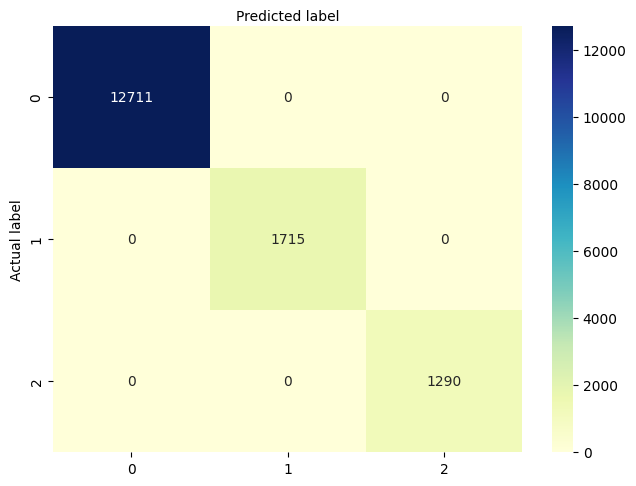

In [49]:
# Evaluate Random Forest
evaluate_model("Random Forest", y_test, rf_pred)

K Nearest Neighbour Accuracy: 0.9980274879104097
K Nearest Neighbour Precision: 0.9980261821465906
K Nearest Neighbour Recall: 0.9980274879104097
K Nearest Neighbour F1 score: 0.9980267409130542
Confusion Matrix for K Nearest Neighbour:


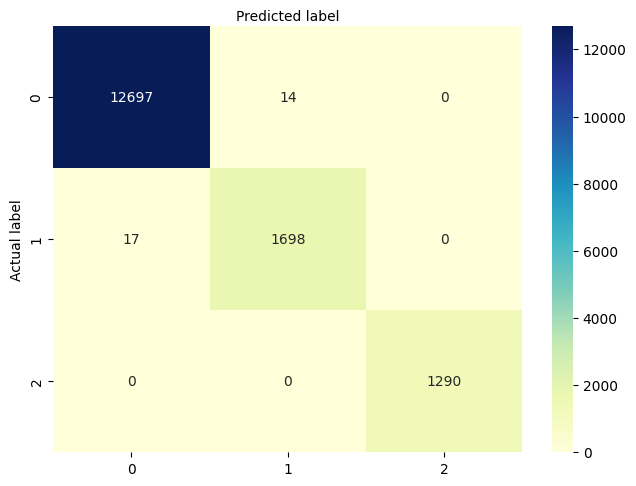

In [50]:
# Evaluate KNN
evaluate_model("K Nearest Neighbour", y_test, knn_pred)

Naive Bayes Accuracy: 0.8358360906082972
Naive Bayes Precision: 0.9344491025362585
Naive Bayes Recall: 0.8358360906082972
Naive Bayes F1 score: 0.8618014608374724
Confusion Matrix for Naive Bayes:


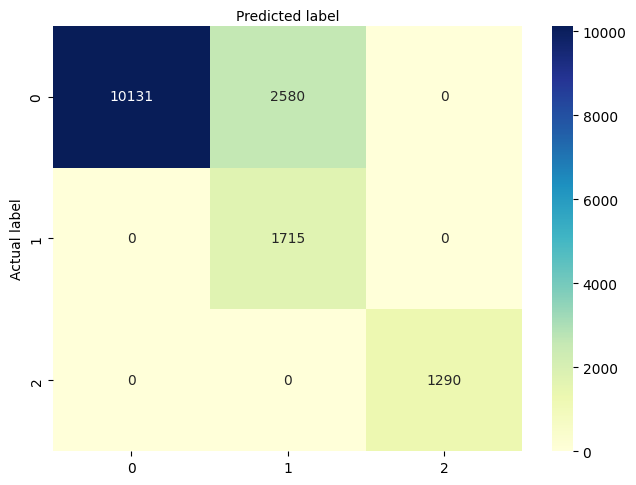

In [51]:
# Evaluate Naive Bayes
evaluate_model("Naive Bayes", y_test, nb_pred)

#Model Deployment

## Save Model

In [52]:
import pickle

In [53]:
with open('encoder.sav', 'wb') as encoder_file:
    pickle.dump(X.columns, encoder_file)

In [54]:
with open('scaler.sav', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

In [55]:
# Save the model to a .sav file
with open('rf_model.sav', 'wb') as model_file:
    pickle.dump(rf_model, model_file)

In [56]:
# loading the saved model
loaded_model = pickle.load(open('rf_model.sav', 'rb'))

In [57]:
for column in X.columns:
  print(column)

amount
login_frequency
session_duration
risk_score
time_category_12pm to 6pm
time_category_6am to 11.59pm
time_category_after 6pm
time_category_before 6am
transaction_type_phishing
transaction_type_purchase
transaction_type_sale
transaction_type_scam
transaction_type_transfer
location_region_Africa
location_region_Asia
location_region_Europe
location_region_North America
location_region_South America
ip_prefix_10.0
ip_prefix_172.0
ip_prefix_172.16
ip_prefix_192.0
ip_prefix_192.168
purchase_pattern_focused
purchase_pattern_high_value
purchase_pattern_random
age_group_established
age_group_new
age_group_veteran


## Streamlit + Ngrok

In [58]:
! pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00


In [59]:
!pip install pyngrok

In [60]:
import os
from threading import Thread
from pyngrok import ngrok

In [61]:
# Add your ngrok token here
ngrok.set_auth_token('2gzeUpTpweDxOLVitHBhOQyVoEJ_7obAGh2vnP6UzgsocjHWm')

In [62]:
def run_streamlit():
    os.system("streamlit run app.py")

In [63]:
# Start a thread to run the Streamlit app
thread = Thread(target=run_streamlit)
thread.start()

In [64]:
# Open a tunnel to the streamlit port 8501
public_url = ngrok.connect(addr='8501', proto='http', bind_tls=True)
print('Your Streamlit app is live at:', public_url)

Your Streamlit app is live at: NgrokTunnel: "https://d92c-35-231-119-177.ngrok-free.app" -> "http://localhost:8501"
